# Install Package & Check GPU

In [98]:
# %pip install pandas
# %pip install matplotlib
# %pip install scikit-learn
# %pip install xgboost

In [99]:
!nvidia-smi

/bin/bash: /home/tyomsarn/miniconda3/envs/ml-64/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Sun Mar 17 02:15:49 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.161.07             Driver Version: 535.161.07   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:87:00.0 Off |                    0 |
| N/A   40C    P0              61W / 400W |   1726MiB / 40960MiB |      0%      Default |
|                                 

In [176]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, f1_score, classification_report, confusion_matrix 
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
import joblib
from time import time 

In [177]:
data_dir = './'
data = pd.read_csv(data_dir + 'final_dataset.csv')

In [178]:
data = data[data.MW > 3]


In [179]:
mw_4 = data[-10:][['HomeTeam', 'AwayTeam']]
mw_4

,HomeTeam,AwayTeam
3570,Crystal Palace,Liverpool
3571,Brighton,Burnley
3572,Man United,Bournemouth
3573,Sheffield United,Brentford
3574,Wolves,Nott'm Forest
3575,Aston Villa,Arsenal
3576,Everton,Chelsea
3577,Fulham,West Ham
3578,Luton,Man City
3579,Tottenham,Newcastle



# Select features
### HTGD - Home team goal difference
### ATGD - away team goal difference
### HTP - Home team points
### ATP - Away team points
### HM1, HM2, HM3 - Home team past-match form
### AM1, MM2, AM3 - Away team past-match form
### DiffFormPts Diff in points
### DiffLP - Differnece in last years prediction

In [180]:
features_labels = data[['FTR', 'HTGD','ATGD','HTP','ATP','HM1', 'HM2', 'HM3', 
                        'AM1', 'AM2', 'AM3','DiffFormPts','DiffLP']]
features_labels.tail()

,FTR,HTGD,ATGD,HTP,ATP,HM1,HM2,HM3,AM1,AM2,AM3,DiffFormPts,DiffLP
3575,H,0.8750,1.1875,2.0000,2.2500,W,D,W,W,W,W,-0.1250,1.0
3576,H,-0.1250,0.1250,1.2500,1.1875,W,W,L,L,W,L,0.1875,3.0
3577,H,-0.3125,0.0625,1.1250,1.5000,W,L,W,W,D,W,-0.0625,1.0
3578,A,-0.8750,1.1875,0.5625,1.8750,L,L,W,L,D,D,0.0625,14.0
3579,H,0.4375,0.9375,1.6875,1.6250,L,D,L,L,W,W,-0.3125,-2.0


array([[<Axes: xlabel='HTGD', ylabel='HTGD'>,
        <Axes: xlabel='ATGD', ylabel='HTGD'>,
        <Axes: xlabel='HTP', ylabel='HTGD'>,
        <Axes: xlabel='ATP', ylabel='HTGD'>,
        <Axes: xlabel='DiffFormPts', ylabel='HTGD'>,
        <Axes: xlabel='DiffLP', ylabel='HTGD'>],
       [<Axes: xlabel='HTGD', ylabel='ATGD'>,
        <Axes: xlabel='ATGD', ylabel='ATGD'>,
        <Axes: xlabel='HTP', ylabel='ATGD'>,
        <Axes: xlabel='ATP', ylabel='ATGD'>,
        <Axes: xlabel='DiffFormPts', ylabel='ATGD'>,
        <Axes: xlabel='DiffLP', ylabel='ATGD'>],
       [<Axes: xlabel='HTGD', ylabel='HTP'>,
        <Axes: xlabel='ATGD', ylabel='HTP'>,
        <Axes: xlabel='HTP', ylabel='HTP'>,
        <Axes: xlabel='ATP', ylabel='HTP'>,
        <Axes: xlabel='DiffFormPts', ylabel='HTP'>,
        <Axes: xlabel='DiffLP', ylabel='HTP'>],
       [<Axes: xlabel='HTGD', ylabel='ATP'>,
        <Axes: xlabel='ATGD', ylabel='ATP'>,
        <Axes: xlabel='HTP', ylabel='ATP'>,
        <Axes: xlabe

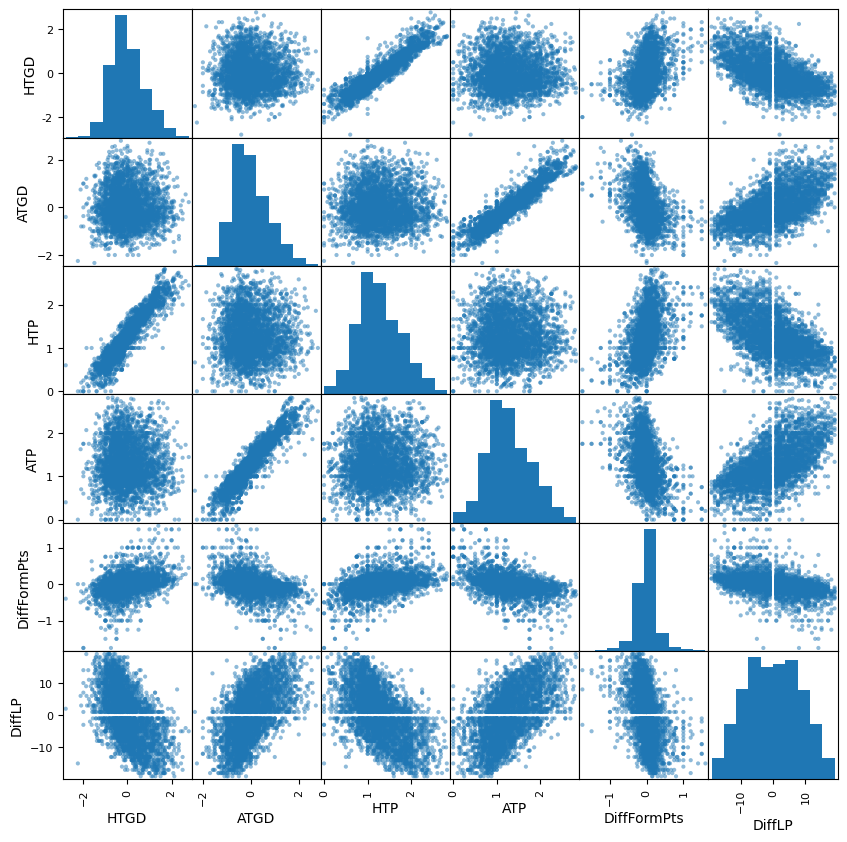

In [181]:
from pandas.plotting import scatter_matrix
scatter_matrix(features_labels[['HTGD','ATGD','HTP','ATP','DiffFormPts','DiffLP']], 
               figsize=(10,10), grid=True)

In [182]:
# Separate into feature set and target variable
# FTR = Full Time Result (H=Home Win, D=Draw, A=Away Win)
X_all = features_labels.drop(['FTR'], axis=1)
y_all = features_labels['FTR']

In [183]:
# Convert last 3 wins columns to string type
X_all['HM1'] = X_all['HM1'].astype(str)
X_all['HM2'] = X_all['HM2'].astype(str)
X_all['HM3'] = X_all['HM3'].astype(str)
X_all['AM1'] = X_all['AM1'].astype(str)
X_all['AM2'] = X_all['AM2'].astype(str)
X_all['AM3'] = X_all['AM3'].astype(str)

def preprocess_features(X):
    ''' Preprocesses the football data and converts categorical variables into dummy variables. '''
    
    # Initialize new output DataFrame
    output = pd.DataFrame(index=X.index)

    # Investigate each feature column for the data
    for col in X.columns:

        # If data type is categorical, convert to dummy variables
        if X[col].dtype == 'object':
            col_data = pd.get_dummies(X[col], prefix=col)
            output = pd.concat([output, col_data], axis=1)
        else:
            # If not categorical, directly join the column to the output DataFrame
            output[col] = X[col]
    
    return output

# Preprocess features
X_all = preprocess_features(X_all)
X_all.tail()


,HTGD,ATGD,HTP,ATP,HM1_D,HM1_L,HM1_W,HM2_D,HM2_L,HM2_W,...,AM1_L,AM1_W,AM2_D,AM2_L,AM2_W,AM3_D,AM3_L,AM3_W,DiffFormPts,DiffLP
3575,0.8750,1.1875,2.0000,2.2500,False,False,True,True,False,False,...,False,True,False,False,True,False,False,True,-0.1250,1.0
3576,-0.1250,0.1250,1.2500,1.1875,False,False,True,False,False,True,...,True,False,False,False,True,False,True,False,0.1875,3.0
3577,-0.3125,0.0625,1.1250,1.5000,False,False,True,False,True,False,...,False,True,True,False,False,False,False,True,-0.0625,1.0
3578,-0.8750,1.1875,0.5625,1.8750,False,True,False,False,True,False,...,True,False,True,False,False,True,False,False,0.0625,14.0
3579,0.4375,0.9375,1.6875,1.6250,False,True,False,True,False,False,...,True,False,False,False,True,False,False,True,-0.3125,-2.0


In [184]:

# Split the data into training and testing sets (70% train, 30% test)
X_train = X_all[:2450]
y_train = y_all[:2450]
X_test = X_all[2450:]
y_test = y_all[2450:]
X_train.shape, y_train.shape, X_test.shape, y_test.shape



((2450, 24), (2450,), (830, 24), (830,))

In [185]:
X_train.head()

,HTGD,ATGD,HTP,ATP,HM1_D,HM1_L,HM1_W,HM2_D,HM2_L,HM2_W,...,AM1_L,AM1_W,AM2_D,AM2_L,AM2_W,AM3_D,AM3_L,AM3_W,DiffFormPts,DiffLP
30,0.25,0.75,1.25,1.50,True,False,False,True,False,False,...,True,False,False,False,True,False,False,True,-0.25,1.0
31,1.75,1.25,2.25,2.25,False,False,True,False,False,True,...,False,True,False,False,True,False,False,True,0.00,-7.0
32,-0.75,-0.75,0.25,0.25,True,False,False,False,True,False,...,False,False,False,True,False,False,True,False,0.00,-9.0
33,0.50,0.50,1.50,1.75,False,False,True,False,True,False,...,False,True,True,False,False,False,False,True,-0.25,-11.0
34,0.25,-0.50,1.00,0.50,False,False,True,True,False,False,...,False,False,True,False,False,False,True,False,0.50,-8.0


In [186]:
# Define columns to be scaled
columns_to_scale = ['HTGD', 'ATGD', 'HTP', 'ATP', 'DiffFormPts', 'DiffLP']

# Filter out columns that are present in X_all
columns_to_scale = [col for col in columns_to_scale if col in X_all.columns]

# Apply StandardScaler only to numerical columns
scaler = StandardScaler()

mask = ('HTGD','ATGD','HTP','ATP','DiffFormPts','DiffLP')
X_train.loc[:, mask] = scaler.fit_transform(X_train.loc[:, mask])
X_test.loc[:, mask] = scaler.transform(X_test.loc[:, mask])


In [187]:
scaler.mean_


array([-0.00767706,  0.00835746,  1.27732379,  1.2876833 , -0.01010108,
       -0.02816327])

# for measuring training time

### F1 score (also F-score or F-measure) is a measure of a test's accuracy. 
### It considers both the precision p and the recall r of the test to compute 
### the score: p is the number of correct positive results divided by the number of 
### all positive results, and r is the number of correct positive results divided by 
### the number of positive results that should have been returned. The F1 score can be 
### interpreted as a weighted average of the precision and recall, where an F1 score 
### reaches its best value at 1 and worst at 0.

In [188]:
def train_classifier(clf, X_train, y_train):
    ''' Fits a classifier to the training data. '''
    
    # Start the clock, train the classifier, then stop the clock
    start = time()
    clf.fit(X_train, y_train)
    end = time()
    
    # Print the results
    print("Trained model in {:.4f} seconds".format(end - start))

    
def predict_labels(clf, features, target):
    ''' Makes predictions using a fit classifier based on F1 score. '''
    
    # Start the clock, make predictions, then stop the clock
    start = time()
    y_pred = clf.predict(features)
    
    end = time()
    # Print and return results
    print("Made predictions in {:.4f} seconds.".format(end - start))
    
    return f1_score(target, y_pred, average='macro'), sum(target == y_pred) / float(len(y_pred))


def train_predict(clf, X_train, y_train, X_test, y_test):
    ''' Train and predict using a classifer based on F1 score. '''
    
    # Indicate the classifier and the training set size
    print("Training a {} using a training set size of {}. . .".format(clf.__class__.__name__, len(X_train)))
    
    # Train the classifier
    train_classifier(clf, X_train, y_train)
    
    # Print the results of prediction for both training and testing
    f1, acc = predict_labels(clf, X_train, y_train)
    print(f1, acc)
    print("F1 score and accuracy score for training set: {:.4f} , {:.4f}.".format(f1 , acc))
    
    f1, acc = predict_labels(clf, X_test, y_test)
    print("F1 score and accuracy score for test set: {:.4f} , {:.4f}.".format(f1 , acc))


In [189]:
# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Define mapping for classes
class_mapping = {'A': 0, 'D': 1, 'H': 2}

# Map the classes to numerical values and transform y_train
y_train_encoded = label_encoder.fit_transform(y_train)

# Define a function to map labels to numerical values
def map_labels_to_numeric(y, mapping):
    return y.map(mapping)

# Map labels in y_test to numerical values manually
label_mapping = {'H': 0, 'D': 1, 'A': 2}
y_test_encoded = map_labels_to_numeric(y_test, label_mapping)


print(np.unique(y_train_encoded))
print(np.unique(y_train))

[0 1 2]
['A' 'D' 'H']


In [113]:
y_train

30      D
31      H
32      D
33      A
34      H
       ..
2655    H
2656    H
2657    H
2658    H
2659    A
Name: FTR, Length: 2450, dtype: object

In [190]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

clf_A = LogisticRegression(random_state = 42)
clf_B = SVC(random_state = 912, kernel='rbf')
clf_C = xgb.XGBClassifier(seed = 82)
train_predict(clf_A, X_train, y_train, X_test, y_test)
print('')
train_predict(clf_B, X_train, y_train, X_test, y_test)
print('')
train_predict(clf_C, X_train, y_train_encoded, X_test, y_test_encoded)
print('')

Training a LogisticRegression using a training set size of 2450. . .
Trained model in 0.0344 seconds
Made predictions in 0.0022 seconds.
0.4469248847130607 0.5685714285714286
F1 score and accuracy score for training set: 0.4469 , 0.5686.
Made predictions in 0.0018 seconds.
F1 score and accuracy score for test set: 0.4490 , 0.5867.

Training a SVC using a training set size of 2450. . .
Trained model in 0.5553 seconds
Made predictions in 0.6112 seconds.
0.522936878786781 0.6257142857142857
F1 score and accuracy score for training set: 0.5229 , 0.6257.
Made predictions in 0.2033 seconds.
F1 score and accuracy score for test set: 0.4523 , 0.5916.

Training a XGBClassifier using a training set size of 2450. . .
Trained model in 0.5502 seconds
Made predictions in 0.0489 seconds.
0.9981782035659852 0.9983673469387755
F1 score and accuracy score for training set: 0.9982 , 0.9984.
Made predictions in 0.0200 seconds.
F1 score and accuracy score for test set: 0.2096 , 0.2108.



In [192]:
# Define the parameter grid for grid search
parameters = {
    'learning_rate': [0.01, 0.001],
    'n_estimators': [50, 100],
    'max_depth': [3, 4],
    'min_child_weight': [1, 2],
    'gamma': [0, 0.1],
    'subsample': [0.6, 0.7],
    'colsample_bytree': [0.6, 0.7], 
    'reg_alpha': [0, 0.001],
    'reg_lambda': [0, 0.001]
    }
# Initialize the classifier
clf = xgb.XGBClassifier(tree_method="hist", device="cuda", seed=82)

# Make an f1 scoring function using 'make_scorer' 
f1_scorer = make_scorer(f1_score, average='macro')

# Perform grid search on the classifier using the f1_scorer as the scoring method
grid_obj = GridSearchCV(clf,
                        scoring=f1_scorer,
                        verbose=2,
                        param_grid=parameters,
                        cv=5)

grid_obj = grid_obj.fit(X_train, y_train_encoded)  # Use y_train_encoded here

# Get the best parameters
best_params = grid_obj.best_params_
from sklearn.metrics import confusion_matrix
print("Best parameters:", best_params)

Fitting 5 folds for each of 512 candidates, totalling 2560 fits
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=50, reg_alpha=0, reg_lambda=0, subsample=0.6; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=50, reg_alpha=0, reg_lambda=0, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=50, reg_alpha=0, reg_lambda=0, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=50, reg_alpha=0, reg_lambda=0, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=50, reg_alpha=0, reg_lambda=0, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_chil

In [193]:
# Get the best estimator from grid search
best_clf = xgb.XGBClassifier(**best_params, tree_method="hist", device="cuda", seed=82)

best_clf = best_clf.fit(X_train, y_train_encoded, eval_set=[(X_train, y_train_encoded), (X_test, y_test_encoded)], verbose=True)


[0]	validation_0-mlogloss:1.09603	validation_1-mlogloss:1.10009
[1]	validation_0-mlogloss:1.09320	validation_1-mlogloss:1.10189
[2]	validation_0-mlogloss:1.09114	validation_1-mlogloss:1.10302
[3]	validation_0-mlogloss:1.08903	validation_1-mlogloss:1.10422
[4]	validation_0-mlogloss:1.08619	validation_1-mlogloss:1.10596
[5]	validation_0-mlogloss:1.08405	validation_1-mlogloss:1.10723
[6]	validation_0-mlogloss:1.08160	validation_1-mlogloss:1.10883
[7]	validation_0-mlogloss:1.07903	validation_1-mlogloss:1.11044
[8]	validation_0-mlogloss:1.07674	validation_1-mlogloss:1.11185
[9]	validation_0-mlogloss:1.07446	validation_1-mlogloss:1.11331
[10]	validation_0-mlogloss:1.07184	validation_1-mlogloss:1.11505
[11]	validation_0-mlogloss:1.06936	validation_1-mlogloss:1.11701
[12]	validation_0-mlogloss:1.06725	validation_1-mlogloss:1.11829
[13]	validation_0-mlogloss:1.06492	validation_1-mlogloss:1.12005
[14]	validation_0-mlogloss:1.06262	validation_1-mlogloss:1.12182
[15]	validation_0-mlogloss:1.06034	

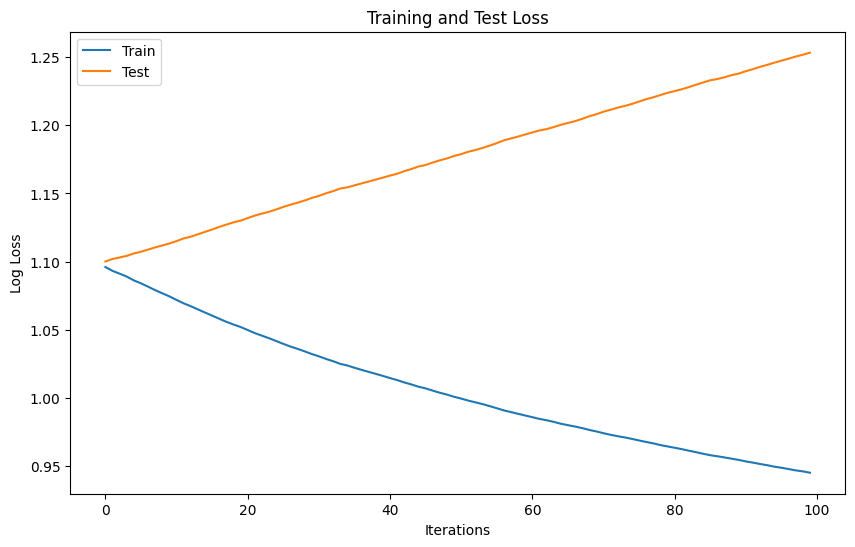

In [194]:
# Generate training loss graph
evals_result = best_clf.evals_result()
train_loss = evals_result['validation_0']['mlogloss']
test_loss = evals_result['validation_1']['mlogloss']
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Train')
plt.plot(test_loss, label='Test')
plt.xlabel('Iterations')
plt.ylabel('Log Loss')
plt.title('Training and Test Loss')
plt.legend()
plt.show()


In [195]:
# Define label mapping
label_mapping = {'H': 0, 'D': 1, 'A': 2}

# Map labels in y_test to numerical values
y_test_encoded = np.array([label_mapping[label] for label in y_test])

# Map predicted labels to numerical values using the label mapping
y_pred = best_clf.predict(X_test)
#y_pred_encoded = np.array([label_mapping.get(label, -1) for label in y_pred])


print("Unique values in y_test_encoded:", np.unique(y_test_encoded))
#print("Unique values in y_pred_encoded:", np.unique(y_pred_encoded))


# Generate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred, labels=[0, 1, 2])
print("Confusion Matrix:")
print(conf_matrix)


Unique values in y_test_encoded: [0 1 2]
Confusion Matrix:
[[ 56   2 324]
 [ 75   0 109]
 [165   1  98]]


In [196]:

# Get unique classes from both y_test_encoded and y_pred_encoded
classes = sorted(set(y_test_encoded) | set(y_pred))

# Map numerical labels back to original class names
class_names = [key for key, value in label_mapping.items() if value in classes]

# Create classification report
report = classification_report(y_test_encoded, y_pred, labels=classes, target_names=class_names)

# Print the classification report
print("Classification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

           H       0.19      0.15      0.17       382
           D       0.00      0.00      0.00       184
           A       0.18      0.37      0.25       264

    accuracy                           0.19       830
   macro avg       0.12      0.17      0.14       830
weighted avg       0.15      0.19      0.15       830



In [197]:
# Save the trained classifier
joblib.dump(clf, 'grid_search_clf.pkl')

# Load the saved classifier back into memory
clf_loaded = joblib.load('grid_search_clf.pkl')

In [199]:
class_mapping = {0: 'A', 1: 'D', 2: 'H'}

# Obtain predictions from the classifier
predictions = best_clf.predict(X_test[:len(mw_4)])

# Map numerical predictions to labels using class_mapping
mapped_predictions = [class_mapping[pred] for pred in predictions]

# Assign mapped predictions to the 'FTR' column of mw_4
mw_4['FTR'] = mapped_predictions
mw_4


,HomeTeam,AwayTeam,FTR
3570,Crystal Palace,Liverpool,A
3571,Brighton,Burnley,H
3572,Man United,Bournemouth,A
3573,Sheffield United,Brentford,A
3574,Wolves,Nott'm Forest,H
3575,Aston Villa,Arsenal,A
3576,Everton,Chelsea,A
3577,Fulham,West Ham,H
3578,Luton,Man City,A
3579,Tottenham,Newcastle,H
